In [65]:
%%capture --no-stderr
%pip install --quiet -U langchain langgraph langchain_google_genai

In [66]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [67]:
import os

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "chatbot-summarization"

In [86]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)


In [87]:
from langgraph.graph import MessagesState

class ChatbotState(MessagesState):
  summary : str

In [88]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
def call_model(state: dict):
    """Checks if there is an existing summary and appends it to the messages."""

    # Accessing the summary from the dictionary
    summary = state.get("summary", "")

    # If a summary exists, append it to the messages
    if summary:
        # Assuming the messages are also in the dictionary
        messages = [SystemMessage(content=summary)] + state["messages"]

    else:
       messages = state["messages"]

    # Now invoke the model with the updated messages list
    response = llm.invoke(messages)

    # Return the model's response wrapped in a dictionary
    return {"messages": response}


In [137]:
def summarize_conversation(state: ChatbotState):
  summary = state.get("summary", "")
  if summary:
    summary_message = (f"This is the summary of tthe conversation to date: {summary}\n"
                     "Extend the summary by taking into account the new messages above"
    )
  else:
    summary_message = "Create the summary of the conversation so far"

  messages = (state["messages"] + [HumanMessage(content=summary_message)])
  response = llm.invoke(messages)

  # delete all messages except the 2 most recent
  delete_messages = [RemoveMessage(id = m.id) for m in state["messages"][:-2]]
  return {"summary" : response.content, "messages" : delete_messages}

In [125]:
from langgraph.graph import END
# prompt: Determine whether to end or summarize the conversation.

def should_end_or_summarize(state: ChatbotState):
  """Determines whether to end or summarize the conversation based on message count."""

  if len(state["messages"]) > 6:
    return "summarize_conversation"  # Summarize if there are 6 or more messages
  else:
    return END # Otherwise, end the conversation

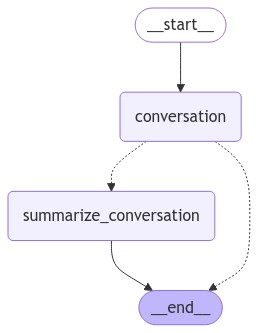

In [138]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver

# Define the nodes
builder = StateGraph(ChatbotState)
builder.add_node("conversation", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

# Define the edges
builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", should_end_or_summarize)
builder.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [139]:
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="Hello!, I am Muhammad.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I like cars!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Muhammad! It's nice to meet you. What can I do for you today?
================================== Ai Message ==================================

You told me your name is Muhammad! Is there anything else I can help you with?
================================== Ai Message ==================================

That's great! Cars are pretty cool. Do you have a favorite car or brand?  I'm always interested in learning about what people love.


In [140]:
graph.get_state(config).values.get("summary","")

''

In [141]:
input_message = HumanMessage(content="I like BMW, and their M series are awesome!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="It's an all in one car")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What do you like about BMW?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


input_message = HumanMessage(content="I will buy it")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

I can see why you like BMWs! They're known for their performance and luxury. And the M series are definitely legendary! Do you have a particular M model in mind?  

I'm curious, what do you like most about them?  The handling? The engine roar? The design?
================================== Ai Message ==================================

You're absolutely right! BMWs, especially the M series, really do offer the whole package.  They're not just fast, they're also comfortable and luxurious.  It's hard to beat that combination!  

What would you say is the most important feature for you in a car? Is it performance, luxury, or something else entirely?
================================== Ai Message ==================================

That's a great question!  I'm not a person, so I don't have personal preferences like you do.  But I can tell you what people often admire about BMWs:

* **Performance:** BMWs are k

In [144]:
graph.get_state(config).values.get("summary","")

'Okay, here\'s an updated summary of our conversation:\n\n* We started by you introducing yourself as Muhammad.\n* You confirmed your name was Muhammad.\n* You shared that you like cars.\n* You expressed your love for BMWs, specifically the M series, and mentioned how awesome they are. \n* You mentioned that BMWs are "all in one" cars, combining performance and luxury.\n* You asked me what I like about BMWs, and I explained their reputation for performance, luxury, design, and technology.\n* You shared that you plan to buy a BMW.\n\nI\'m excited to continue chatting with you about cars!  Do you have any other thoughts about BMWs, or any other car topics you\'d like to discuss? \n'